## Punto 0

In [48]:
"""

Il dataset wildlife.csv è posto nella cartella esame sul desktop del vostro PC.
Lo schema del dataset è:
    AC_CLASS; AC_MASS; NUM_ENGS; INCIDENT_MONTH; INCIDENT_YEAR; HEIGHT;
    SPEED; PHASE_OF_FLT; DAMAGE; BIRDS_STRUCK; SIZE; WARNED

Il separatore adottato è il carattere “;”

Il file registra gli impatti tra volatili e aeroplani dal 2010 a oggi. In particolare:

AC_CLASS 
    Type of aircraft
    A: Airplane
    B: elicopter
    Empty: Unknown

AC_MASS
    1 = 2,250 kg or less: 
    2 = ,2251-5700 kg
    3 = 5,701-27,000 kg
    4 = 27,001-272,000 kg 
    5 = above 272,000 kg

NUM_ENGS
    Number of engines

PHASE_OF_FLT
    Phase of flight during which strike occurred
    1: Parked / Taxi
    2: Approach
    3: Climb
    4: Departure/Take off
    5: En Route
    6: Descent
    7: Landing roll

DAMAGE
    U = Unknown
    N = no problem
    M = minor
        When the aircraft can be rendered airworthy by simple repairs or replacements and an extensive 
        inspection is not necessary.
    M? = uncertain level
        The aircraft was damaged, but details as to the extent of the damage are lacking.
    S = substantial
        When the aircraft incurs damage or structural failure which adversely affects the structure strength, 
        performance or flight characteristics of the aircraft and which would normally require major repair 
        or replacement of the affected component.
    D = Destroyed
        When the damage sustained makes it inadvisable to restore the aircraft to an airworthy condition.

BIRDS_STRUCK
    0: unknown
    1:  1
    2: 2-10
    3: 11-100
    4: > 100

SIZE
    Small
    Medium
    Large
    Unknown

WARNED
    Pilot warned of birds/wildlife
    Yes
    No
    Unknown
"""
# Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2

## Parte 1

### Punto 1.1

In [2]:
path = 'wildlife0901.csv'
dataset = pd.read_csv(path, sep = ';')
dataset.head()

,AC_CLASS,AC_MASS,NUM_ENGS,INCIDENT_MONTH,INCIDENT_YEAR,HEIGHT,SPEED,PHASE_OF_FLT,DAMAGE,BIRDS_STRUCK,SIZE,WARNED
0,A,1,1.0,9,2011,0,0,1,N,1,Small,N
1,A,1,1.0,5,2013,0,0,1,S,1,Large,N
2,A,1,1.0,9,2013,0,0,1,N,1,Small,Y
3,A,1,1.0,12,2013,0,0,1,N,1,Small,N
4,B,1,1.0,7,2010,0,0,1,N,1,Medium,Y


### Punto 1.2

In [3]:
"""
Quanti sono gli incidenti che hanno coinvolto elicotteri?
Quanti hanno coinvolto areoplani?
"""
incidenti_class = dataset.groupby('AC_CLASS').size()
incidenti_A = incidenti_class['A']
incidenti_B = incidenti_class['B']

incidenti_nan = dataset['AC_CLASS'].isna().sum()

print('Numero totale di incidenti è:', dataset.shape[0])
print('Numero degli incidenti elicotteri:', incidenti_A)
print('Numero degli incidenti aereoplani:', incidenti_B)
print('Numero degli sconosciuti', incidenti_nan)

Numero totale di incidenti è: 16122
Numero degli incidenti elicotteri: 15617
Numero degli incidenti aereoplani: 482
Numero degli sconosciuti 23


### Punto 1.3

Il mese con il numero di alti di incidenti è 9 con 2152

****************************************************************************************************


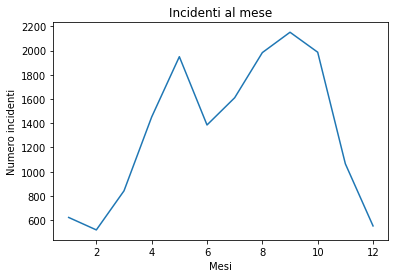

In [4]:
"""
Raggruppare gli incidenti per mesi e visualizzarli in un grafico. Qual è il mese con il maggior 
numero di incidenti? 
"""
incidenti_mese = dataset.groupby('INCIDENT_MONTH').size()
idx_mese_max = incidenti_mese.idxmax()
values_mese_max = incidenti_mese.max()

print('Il mese con il numero di alti di incidenti è {} con {}\n'. format(idx_mese_max, values_mese_max))
print('*' * 100)

plt.plot(incidenti_mese)
plt.title('Incidenti al mese')
plt.xlabel('Mesi')
plt.ylabel('Numero incidenti')
plt.show()

### Punto 1.4

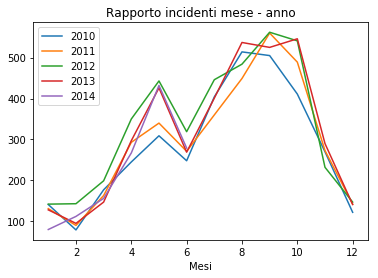

****************************************************************************************************
INCIDENT_YEAR    2010   2011   2012   2013   2014
INCIDENT_MONTH                                   
1               141.0  131.0  142.0  128.0   80.0
2                79.0   90.0  143.0   95.0  112.0
3               177.0  163.0  199.0  147.0  156.0
4               245.0  293.0  350.0  297.0  267.0
5               309.0  340.0  443.0  426.0  432.0
6               248.0  271.0  319.0  269.0  279.0
7               404.0  360.0  446.0  401.0    NaN
8               514.0  449.0  484.0  537.0    NaN
9               505.0  560.0  562.0  525.0    NaN
10              411.0  489.0  541.0  546.0    NaN
11              270.0  273.0  232.0  290.0    NaN
12              122.0  142.0  147.0  141.0    NaN


In [5]:
"""
Creare un nuovo dataset (chiamato “summary”) nel quale rappresentare sulle righe i mesi e sulle colonne 
gli anni. E’ possibile individuare attraverso una rappresentazione grafica un trend nella frequenza 
degli incidenti?
"""
summary = dataset.groupby(['INCIDENT_MONTH', 'INCIDENT_YEAR']).size().unstack()
plt.plot(summary)
plt.title('Rapporto incidenti mese - anno')
plt.legend(summary.columns)
plt.xlabel('Mesi')
plt.show()

# Print
print('*' * 100)
print(summary)

## Parte 2

### Punto 1.2

In [6]:
"""
Scikit-learn utilizza un array numpy per effettuare le proprie predizioni. Gli elementi 
dell’array numpy devono essere delle stesso data type. E’ necessario pertanto trasformare i 
dati del dataset per renderli utilizzabili con scikit.

Trasformare i valori dei campi DAMAGE, SIZE, WARNED adottando i seguenti valori:
    * DAMAGE
        U = 0
        N = 1
        M = 3
        M?= 5
        S = 7
        D = 9
    *SIZE
        Small = 1
        Medium = 3
        Large = 5
        Unknown = 0
    *WARNED
        N = 0
        Y = 1
        Unknown = 3
"""
# Copio il dizionario
dataset_new = dataset.copy()
#Creo i dizionari
dict_damage = {'U' : 0, 'N' : 1, 'M' : 3, 'M?' : 5, 'S' : 7, 'D' : 7}
dict_size = {'Small' : 1, 'Medium' : 3, 'Large' : 5, 'Unknown' : 0}
dict_warned = {'N' : 0, 'Y' : 1, 'n': 0, 'y' : 1, 'Unknown' : 3}
# Applico la trasformazione. Potevo anche usare 'replace'
dataset_new['DAMAGE'] = dataset_new['DAMAGE'].map(dict_damage)
dataset_new['SIZE'] = dataset_new['SIZE'].map(dict_size)
dataset_new['WARNED'] = dataset_new['WARNED'].map(dict_warned)
# Si potevano anche rappuggrare i dataset e applicare tutti insieme. Soluzione più rapida

# Controllo i valori
value_damage = dataset_new['DAMAGE'].unique()
value_size = dataset_new['SIZE'].unique()
value_warned = dataset_new['WARNED'].unique()
print('Valori DAMAGE:', value_damage)
print('Valori SIZE:', value_size)
print('Valori WARNED:', value_warned)

Valori DAMAGE: [1 7 3 5]
Valori SIZE: [1 5 3 0]
Valori WARNED: [0 1 3]


In [7]:
"""
Creare un nuovo dataset che consideri solo gli aeroplani e gli incidenti che coinvolgono animali 
con una dimensione nota. Denominare il dataset  “data_air”. In data_air eliminare poi l’attributo
AC_CLASS divenuto irrilevante. 
"""
data_air = dataset_new.copy()
data_air = data_air[data_air['AC_CLASS'] == 'A']
data_air = data_air[data_air['SIZE'] != 0]
data_air = data_air.drop('AC_CLASS', axis = 1)

#Confronto dimensioni
print('Dimensioni iniziali:', dataset_new.shape[0])
print('Dimensioni finali:', data_air.shape[0])
num_A = dataset_new[dataset_new['AC_CLASS'] == 'B'].shape[0] + dataset_new['AC_CLASS'].isna().sum()
num_0 = dataset_new[dataset_new['SIZE'] == 0].shape[0]
print('Dimensioni CLASS uguali B o NaN {}. Con SIZE uguale a 0 {}'.format(num_A, num_0))

Dimensioni iniziali: 16122
Dimensioni finali: 14842
Dimensioni CLASS uguali B o NaN 505. Con SIZE uguale a 0 797


### Punto 2.3

In [8]:
"""
Eliminare le righe che contengono almeno un element NaN
"""
data_air = data_air.dropna(axis = 1)

### Punto 2.4

In [9]:
"""
Si vuole predire la dimensione dell’animale sulla base degli altri attributi presenti nel datase.
Dividere “data_air” in modo che ¾ degli elementi siano contenuti in un nuovo dataset “train” e ¼ nel 
dataset “test”.

Valutare l’accuracy ottenuta con il modello BernoulliNB
(from sklearn.naive_bayes import BernoulliNB)
"""
Y = data_air['SIZE']
X = data_air.drop('SIZE', axis = 1)

test_size = 0.33
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = test_size, random_state = 0)
bernoulliNB = BernoulliNB()
bernoulliNB.fit(X_train, Y_train)
score = bernoulliNB.score(X_test, Y_test)
print('Accuracy: {:0.3f}'.format(score))

Accuracy: 0.697


### Punto 2.5

In [10]:
"""
Il valore di accuratezza ottenuto è abbastanza elevato, tuttavia, cosa si scopre analizzando 
la confusion matrix?
"""
y_pred_BNB = bernoulliNB.predict(X_test)
confusion_matrix_BNB = confusion_matrix(Y_test, y_pred_BNB)
print('Confusion Matrix Bernoulli BNB:\n', confusion_matrix_BNB)

Confusion Matrix Bernoulli BNB:
 [[3411    0    2]
 [1100    0    2]
 [ 381    0    2]]


### Punto 2.6

In [11]:
"""
Se si utilizza un modello basato su Decision Tree che valore di accuratezza si ottiene? Cambia
qualcosa nella confusion matrix?
"""
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
score = decision_tree.score(X_test, Y_test)
y_pred_DT = decision_tree.predict(X_test)
confusion_matrix_DT = confusion_matrix(Y_test, y_pred_DT)
print('Accuracy DECISION TREE: {:0.3f}'.format(score))
print('Confusion matrix DECISION TREE:\n', confusion_matrix_DT)

Accuracy DECISION TREE: 0.612
Confusion matrix DECISION TREE:
 [[2572  680  161]
 [ 666  317  119]
 [ 154  120  109]]


### Punto 2.7

In [12]:
"""
Si analizzi il dataset “data_air” e si crei un nuovo training set “bilanciato” composto cioè di ¾ delle
istanze aventi valore di SIZE = 1 (Small), ¾ delle istanze aventi valore di SIZE =3 (Medium), ¾ delle 
istanze aventi valore di SIZE = 5 (Large) e aventi come test set il rimanente delle istanze. 
Come cambia l’accuratezza considerando sempre un modello basato su Decision Tree? Cambia qualcosa nella 
confusion matrix?
"""
dataset_bilanced = data_air.copy()

one = dataset_bilanced[dataset_bilanced['SIZE'] == 1]
three = dataset_bilanced[dataset_bilanced['SIZE'] == 3]
five = dataset_bilanced[dataset_bilanced['SIZE'] == 5]

test_size = 0.33
train_one, test_one = train_test_split(one, test_size = test_size)
train_three, test_three = train_test_split(five, test_size = test_size)
train_five, test_five = train_test_split(three, test_size = test_size)

train = pd.concat([train_one, train_three, train_five])
test = pd.concat([test_one, test_three, test_five])

Y_train = train['SIZE']
X_train = train.drop('SIZE', axis = 1)
Y_test = test['SIZE']
X_test = test.drop('SIZE', axis = 1)

decision_tree.fit(X_train, Y_train)
y_pred_bal = decision_tree.predict(X_test)
score_bal = decision_tree.score(X_test, Y_test)
confusion_matrix_bal = confusion_matrix(Y_test, y_pred_bal)

print('Accuracy DECISION TREE con dataset bilanciato: {:0.3f}'.format(score_bal))
print('Confusion matrix DECISION TREE con dataset bilanciato:\n', confusion_matrix_bal)

Accuracy DECISION TREE con dataset bilanciato: 0.612
Confusion matrix DECISION TREE con dataset bilanciato:
 [[2576  673  168]
 [ 663  310  125]
 [ 156  116  112]]


### Punto 2.8

In [44]:
"""
Si consideri un nuovo dataset ottenuto attraverso una variazione a piacere del precedente e si analizzi 
l’accuratezza ottenuta con un modello basato su Decision Tree. Che valore si ottiene?
"""
dataset_z = data_air.copy()
# Replico i dati per aumentare il numero di esempi
dataset_z = pd.concat([dataset_z, dataset_z, dataset_z])

# Trasformo SPEED Tra 0 a 1
scaler = MinMaxScaler()
scaler.fit(dataset_z[['SPEED']])
dataset_z['SPEED'] = scaler.transform(dataset_z[['SPEED']])


# Creo due nuove colonne con 1 se l'incidente è avvenuto sopra l'altezza e la velocità media, altrimenti 0
mean_height = np.mean(dataset_z['HEIGHT'])
mean_speed = np.mean(dataset_z['SPEED'])
dataset_z['HEIGHT_MEAN'] = np.where(dataset_z['HEIGHT'] > mean_height, 1, 0)
dataset_z['SPEED_MEAN'] = np.where(dataset_z['SPEED'] < mean_speed, 1, 0)

# Creo i dummies di DAMAGE
dummies_damage = pd.get_dummies(dataset_z['DAMAGE'])
dataset_z = pd.concat([dataset_z, dummies_damage], axis = 1)

# Raggruppo i mesi per stagioni
seasons = [1, 2, 3, 4]
num_seasons = 4
dataset_z['SEASON'] = pd.qcut(dataset_z['INCIDENT_MONTH'], q = num_seasons, labels= seasons)

Y = dataset_z['SIZE']
X = dataset_z.drop('SIZE', axis = 1)


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33, random_state = 1)

decision_tree.fit(X_train, Y_train)
score = decision_tree.score(X_test, Y_test)
y_pred_DT = decision_tree.predict(X_test)
confusion_matrix_DT = confusion_matrix(Y_test, y_pred_DT)
print('Accuracy DECISION TREE: {:0.3f}'.format(score))
print('Confusion matrix DECISION TREE:\n', confusion_matrix_DT)

Accuracy DECISION TREE: 0.922
Confusion matrix DECISION TREE:
 [[9751  358   82]
 [ 491 2801   51]
 [ 100   64  996]]


### Punto 2.9

In [49]:
"""
Che valore di accuratezza si ottiene con un 5 Fold cross validation e un modello basato su Decision Tree
"""
num_folds = 5
scores = cross_val_score(decision_tree, X, Y, cv = num_folds)
print('Accuracy {:.04f} ({:.04f})'.format(scores.mean(), scores.std()))

Accuracy 0.9711 (0.0049)
